In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
identifier_name = 'flight_id'

features_names = [
    'month-day',
    'month',
    'day_in_month',
    'adep', 
    'country_code_adep', 
    'ades', 
    'country_code_ades', 
    'aircraft_type', 
    'wtc', 
    'airline', 
    'flight_duration', 
    'taxiout_time', 
    'flown_distance', 
    'actual_offblock_time_hour', 
    'actual_offblock_time_minute', 
    'actual_offblock_time_hour_minute', 
    'arrival_time_hour', 
    'arrival_time_minute', 
    'arrival_time_hour_minute'
]

target_name = 'tow'

global_random_state = 123

In [3]:
encoded_challenge_set = pd.read_csv('../../data/encoded_challenge_set.csv')

# Pick up features from dataset
features = encoded_challenge_set[features_names]

# Pick up target from dataset
target = encoded_challenge_set[target_name]

global_random_state = 123

In [4]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=global_random_state)

In [5]:
# Step 1: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features).round(2)

# Step 2: Apply PCA
pca = PCA(n_components=0.99)  # Keeps 99% of the explained variance
X_pca = pca.fit_transform(features_scaled)
    
# Step 3: Grid Search XGBoost on the PCA-transformed data
param_grid = {
    'n_estimators': list(range(1,102,15)),
    'max_depth': list(range(1, 11, 3)),
    'learning_rate': [x / 10 for x in list(range(1, 10, 3))],
    'subsample': [x / 10 for x in list(range(1, 11, 3))],
    'colsample_bytree': [x / 10 for x in list(range(1, 11, 3))]
}

model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=global_random_state
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use RMSE (negative because scikit-learn maximizes scores)
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_pca, target)

best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best RMSE:", -grid_search.best_score_) # Negate the score to get RMSE

Fitting 3 folds for each of 1344 candidates, totalling 4032 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 91, 'subsample': 1.0}
Best RMSE: 5438.255723864183


<Figure size 1000x800 with 0 Axes>

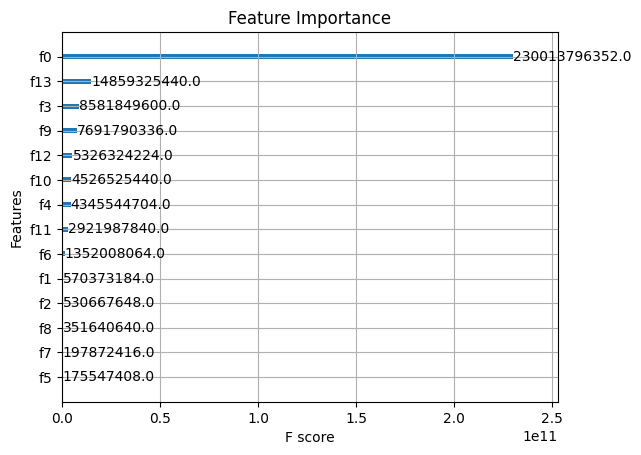

In [6]:
best_model = grid_search.best_estimator_

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='gain')
plt.title('Feature Importance')
plt.show()